# Transfer learning with TensorFlow - Fine-tuning
It's time to learn about a new kind of tranfer learning: fine-tuning.

In [2]:
# check if we're using GPU
!nvidia-smi

Sat Jul  8 04:32:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
We've created a bunch of helper function, let's import it.

It's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere)

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-08 04:32:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-08 04:32:12 (85.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions we're going to use in this notebooks
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're running this notebook in Google colab, when it times out colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem(recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of  food 101 dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-07-08 04:32:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   155MB/s    in 1.0s    

2023-07-08 04:32:22 (155 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
unzip_data("10_food_classes_10_percent.zip")

In [7]:
# check out how many images and subdirecotries are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [8]:
# create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [9]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# checkout class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# see an example of a batch of data
for images , labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[4.50561218e+01 3.10561237e+01 3.10561237e+01]
   [4.71683693e+01 3.51683693e+01 3.51683693e+01]
   [5.13622437e+01 3.93622437e+01 3.93622437e+01]
   ...
   [9.42143326e+01 1.01642860e+02 1.09000069e+02]
   [1.06326408e+02 1.10540733e+02 1.19469292e+02]
   [9.54849167e+01 1.04025757e+02 1.13255333e+02]]

  [[5.13061218e+01 3.93061218e+01 3.93061218e+01]
   [5.56428604e+01 4.36428604e+01 4.36428604e+01]
   [5.72142868e+01 4.52142868e+01 4.52142868e+01]
   ...
   [9.43979187e+01 1.03683594e+02 1.10112228e+02]
   [9.44898224e+01 1.01622498e+02 1.11556160e+02]
   [9.38877258e+01 1.04836807e+02 1.13505142e+02]]

  [[5.69234695e+01 4.53520393e+01 4.55663261e+01]
   [5.54846916e+01 4.39132652e+01 4.41275482e+01]
   [5.86224518e+01 4.86683693e+01 4.80969391e+01]
   ...
   [9.49540634e+01 1.04336678e+02 1.12831627e+02]
   [9.44949112e+01 1.04724541e+02 1.13867386e+02]
   [9.25101852e+01 1.08148033e+02 1.16576576e+02]]

  ...

  [[3.46531334e+01 5.62246056e+01 5.34388695e+01]
   [3

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models- https://www.tensorflow.org/guide/keras/functional

In [13]:
# 1. Create base model with tf.keras.applications
base_model= tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pretrained aren't updated during training )
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using  a model like ResNet50V2 you will need to normalize inputs(you don't want for EfficientNetB0 it is built in )
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing the inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss= "categorical_crossentropy",
    optimizer= "adam",
    metrics=["accuracy"]
)

# 10. fit the model
history = model_0.fit(train_data_10_percent,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=(test_data),
                      validation_steps=(0.25 * len(test_data)),
                      epochs=5,
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                             experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step


Shape after passing the inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230708-043244
Epoch 1/5
24/24 [==============================] - 21s 264ms/step - loss: 1.8016 - accuracy: 0.4640 - val_loss: 1.2423 - val_accuracy: 0.7266
Epoch 2/5
24/24 [==============================] - 5s 176ms/step - loss: 1.0495 - accuracy: 0.7773 - val_loss: 0.8520 - val_accuracy: 0.8062
Epoch 3/5
24/24 [==============================] - 5s 176ms/step - loss: 0.7709 - accuracy: 0.8320 - val_loss: 0.6776 - val_accuracy: 0.8594
Epoch 4/5
24/24 [==============================] - 4s 145ms/step - loss: 0.6238 - accuracy: 0.8547 - val_loss: 0.6024 - val_accuracy: 0.8594
Epoch 5/5
24/24 [==============================] - 5s 176ms/step - loss: 0.5455 - accuracy: 0.8693 - val_loss: 0.5378 - val_accuracy: 0.8687


In [14]:
# evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.5518 - accuracy: 0.8616


[0.5517536401748657, 0.8615999817848206]

In [15]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [16]:
# summary of base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [17]:
# summary of our model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


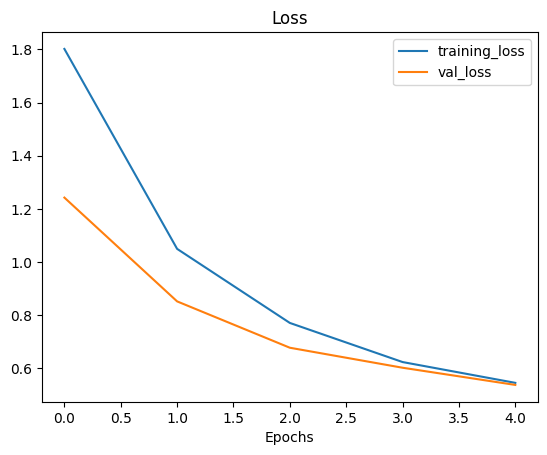

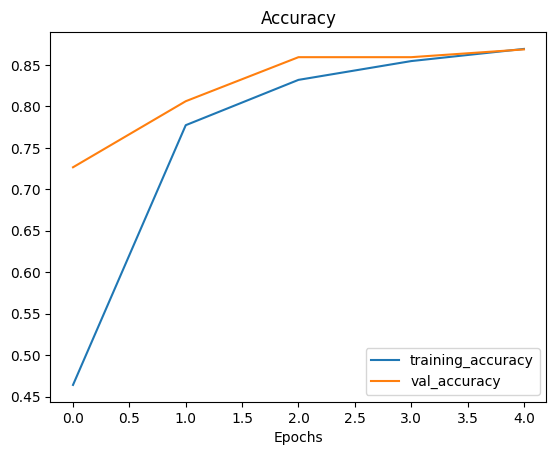

In [18]:
# check out training model's training
plot_loss_curves(history)

## Getting feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through 'base_model' of shape (None, 7, 7 , 1280).

But then when it passes through the GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3 and then pass it to GlobalAveragePooling2D)

In [21]:
# define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of Global Average Pooling 2Dtensor:{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:(1, 4, 4, 3)
Shape of Global Average Pooling 2Dtensor:(1, 3)


In [22]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

 Let's check out GlobalMaxPooling layer

In [23]:
# create a input tensor
input_shape= (1,4,4,3)

# set seed
tf.random.set_seed(42)
tensor = tf.random.normal(input_shape)

# Pass the tensor through the GlobalMAxPooling
global_maxpooling = tf.keras.layers.GlobalMaxPooling2D()(tensor)

# printing all outputs
print(f"Random input tensor:\n{tensor}\n")
print(f"GlobalMaxPooling tensor: \n{global_maxpooling}\n")
print(f"Random tensor shape: {tensor.shape}\n")
print((f"GlobalMaxPooling tensor shape:{global_maxpooling.shape}\n"))

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

GlobalMaxPooling tensor: 
[[0.9058464 1.1603122 1.6994323]]

Random tensor shape: (1, 4, 4, 3)

GlobalMaxPooling tensor shape:(1, 3)



In [27]:
# let's replicate GlobalMAxPooling
tf.reduce_max(tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happen is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case,  this is the output of the `tf.keras.layers.GlobalAveragePooling2D()`layer which can then be used to extract patterns out of our own specific problem.

### Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how about we set up a bunch of experiments to find out:

1. `model_1` - Use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2` - Use feature extraction transfer learning with 10% of the training with data augmentation

3. `model_3` - Use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4` - Use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [29]:
# Download and unzip data - preprocessed from food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-07-08 05:35:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  32.5MB/s    in 3.9s    

2023-07-08 05:35:39 (32.5 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [30]:
# Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [32]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [33]:
# Setup data loaders
IMG_SIZE= (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) #default =32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits  of doing this within the TensorFlow Data Augmentation Documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

After reading the benefits of using data augmentation inside the model are:
* Preprocessing of images(augmenting them) happens on the GPU(much faster) rather than the CPU.
* Image data augmentation only happens during training , so we can still export our whole model and use it elsewhere.

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, rooms , zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescale(1/255.) # keep for models like ResNEt50V2 but EfficientNet's Having rescaling builtin
   ],name="data_augmentation")



In [ ]:
### Visualize our data augmentation layer (and see what happens)